# **BCDI Pipeline**  
### A Notebook to Run the `BcdiPipeline` Instance  

This notebook provides a structured workflow for running a **Bragg Coherent Diffraction Imaging (BCDI) pipeline**.  

The `BcdiPipeline` class handles the entire process, including:  
- **Pre-processing** → Data preparation and corrections.  
- **Phase retrieval** → Running PyNX algorithms to reconstruct the phase.  
- **Post-processing** → Refining, analysing (get the strain!), and visualising results.  

You can provide **either**:  
- A **YAML parameter file** for full automation.  
- A **Python dictionary** for interactive control in this notebook.  


In [1]:
# import required packages
import os

import cdiutils  # core library for BCDI processing

## **General Parameters**
Here, define the key parameters for **accessing and saving data** before running the pipeline.  
- **These parameters must be set manually by the user** before execution.  
- The output data will be saved in a structured directory format based on `sample_name` and `scan`. However, you can change the directory path if you like.


> **Notes for P10 users:**
> - for this beamline, the `experiment_file_path` is replaced by `experiment_data_dir_path`, it is where to find the raw data files.
> - the `sample_name` is the sample name that was used on the beamline, in the data file organisation the datasets follow: `sample_name_0001` pattern. The scan number is the 4-digit number after the underscore is handled automatically by the `scan` parameter. In the case below, the folder containing our dataset is called `Pd_YSZ_0037`.
> - as P10 uses a Eiger 4M detector, loading a rocking curve is often memory consuming, so I recommend to use `light_loading=True` in the preprocessing step and directly providing the voxel of reference (i.e. the centre of the Bragg peak) in the `voxel_reference_methods` parameter, this will avoid loading the full dataset and search for the peak position.
> - the `det_calib_params` must be provided, I haven't implemented automatic reading from the scan file yet.
> - the default `detector_name` is set to `e4m`, but you can change it if needed (in the preprocessing step).

Enjoy!

In [2]:
# define the key parameters (must be filled in by the user)
beamline_setup: str = "p10"  # example: "ID01" (provide the beamline setup)
experiment_data_dir_path: str = (
    "/scisoft/cdiutils_test_data/p10"  # example: "/path/to/experiment/file.h5"
)
sample_name: str = "Pd_YSZ"  # example: "Sample_Pt" (specify the sample name)
scan: int = 37  # example: 42 (specify the scan number)

# choose where to save the results (default: current working directory)
dump_dir = os.getcwd() + f"/results/{sample_name}/S{scan}/"

# load the parameters and parse them into the BcdiPipeline class instance
params = cdiutils.pipeline.get_params_from_variables(dir(), globals())
bcdi_pipeline = cdiutils.BcdiPipeline(params=params)

[INFO] BcdiPipeline initialised.



Dump directory already exists, results will be saved in:
/gpfs/jazzy/data/scisoft/clatlan/experiments/p10_june_24/results/Pd_YSZ/S37/.


## **Pre-Processing**  

If you need to update specific parameters, you can **pass them directly** into the `preprocess` method.  

### **Main Parameters**
- `preprocess_shape` → The shape of the cropped window used throughout the processes.  
  - Can be a **tuple of 2 or 3 values**.  
  - If only **2 values**, the entire rocking curve is used.  

- `voxel_reference_methods` → A `list` (or a single value) defining how to centre the data.  
  - Can include `"com"`, `"max"`, or a `tuple` of `int` (specific voxel position).  
  - Example:
    ```python
    voxel_reference_methods = [(70, 200, 200), "com", "com"]
    ```
    - This centres a box of size `preprocess_shape` around `(70, 200, 200)`, then iteratively refines it using `"com"` (only computed within this box).
    - Useful when `"com"` fails due to artifacts or `"max"` fails due to hot pixels.  
    - Default: `["max", "com", "com"]`.  

- `rocking_angle_binning` → If you want to bin in the **rocking curve direction**, provide a binning factor (ex.: `2`).  

- `light_loading` → If `True`, loads only the **ROI of the data** based on `voxel_reference_methods` and `preprocess_output_shape`.  

- `hot_pixel_filter` → Removes isolated hot pixels. 
  - Default: `False`.  

- `background_level` → Sets the background intensity to be removed.  
  - Example: `3`.  
  - Default: `None`.  

- `hkl` → Defines the **Bragg reflection** measured to extend *d*-spacing values to the lattice parameter.  
  - Default: `[1, 1, 1]`.  


[INFO] 
*******************************************************************************
*                        Starting process: preprocess                         *
*******************************************************************************

[INFO] Additional parameters provided, will update the current dictionary of parameters.
[INFO] 
Shape already in agreement with pynx shape conventions.

[INFO] 
Light loading requested, will use ROI [200, 400, 1226, 1426, 1389, 1589] and bin along rocking curve direction by None during data loading.
[INFO] Energy successfully loaded (10574.286342558808 eV).
[INFO] background_level set to 2, will remove the background.
[INFO] 
Oversampling ratios calculated from diffraction pattern are: axis0: 2.3, axis1: 8.3, axis2: 5.3. If low-strain crystal, you can set PyNX 'rebin' parameter to (1.0, 4.0, 2.0)
[INFO] 
Summary table:
╒═════════╤═════════════════════╤═══════════════════╤════════════════╤═════════════════╕
│ voxel   │ uncrop. det. pos.   │ 

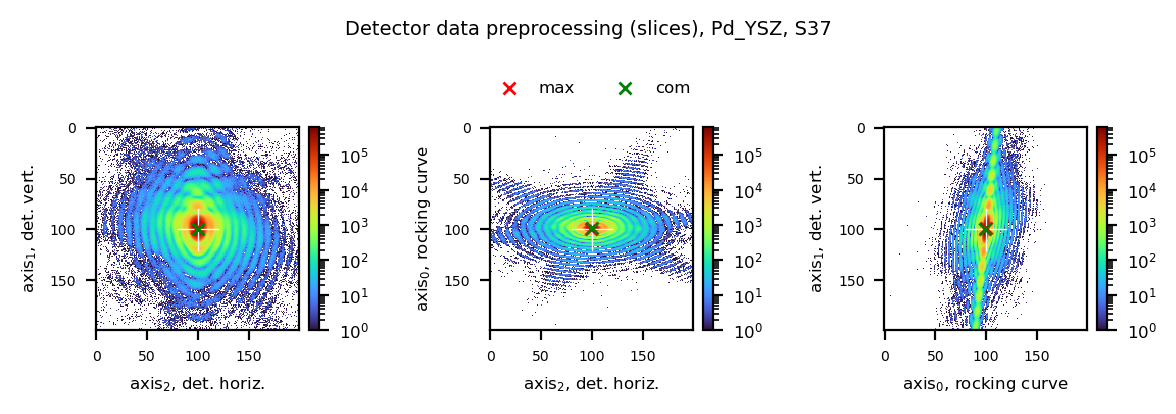

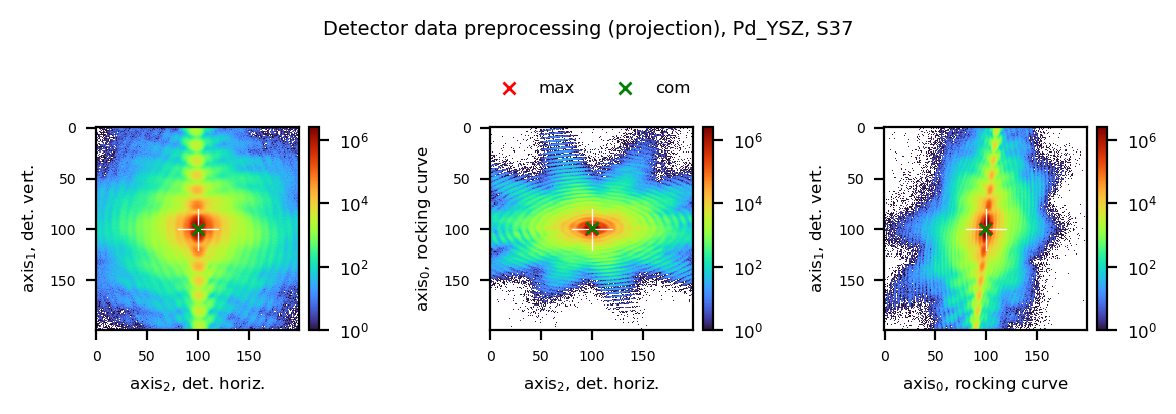

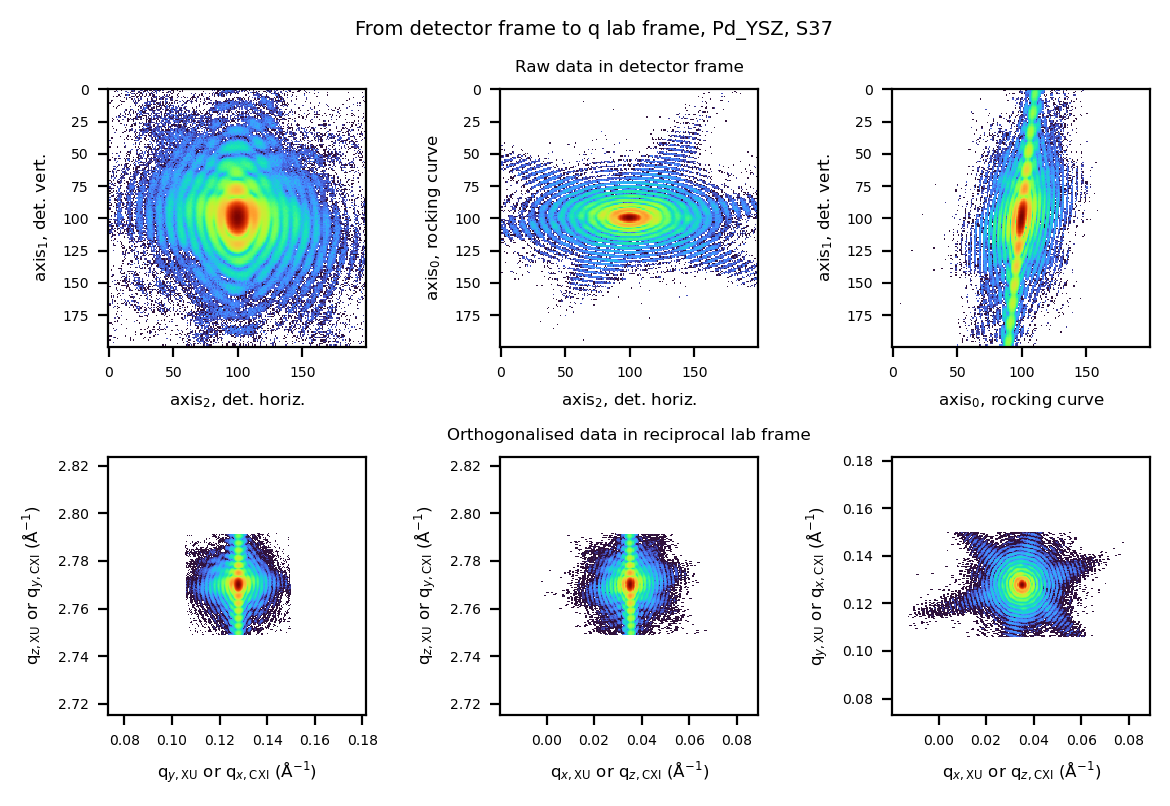

In [ ]:
bcdi_pipeline.preprocess(
    preprocess_shape=(200, 200, 200),  # define cropped window size
    voxel_reference_methods=[(300, 1326, 1489)],  # centring method sequence
    hot_pixel_filter=False,  # remove isolated hot pixels
    background_level=2,  # background intensity level to remove
    light_loading=True,  # use light loading to save memory upon loading
    det_calib_params={
        "distance": 1.82169,  # direct beam position vertical,
        "cch1": 1055.74,  # horizontal
        "cch2": 1332.94,  # detector pixel size in m
        "pwidth1": 7.5e-05,  # detector pixel size in m
        "pwidth2": 7.5e-05,  # sample to detector distance in m
        "detrot": 0,
        "tilt": 0,
        "tiltazimuth": 0,
    },
)

## **[PyNX](https://pynx.esrf.fr/en/latest/index.html) Phase Retrieval**
See the [pynx.cdi](https://pynx.esrf.fr/en/latest/scripts/pynx-cdi-id01.html) documentation for details on the phasing algorithms used here.  

**Algorithm recipe**

You can either:  
- provide the exact chain of algorithms.  
- or specify the number of iterations for **RAAR**, **HIO**, and **ER**.  

```python
algorithm = None  # ex: "(Sup * (ER**20)) ** 10, (Sup*(HIO**20)) ** 15, (Sup*(RAAR**20)) ** 25"
nb_raar = 500
nb_hio =  300
nb_er =  200
psf = "pseudo-voigt,1,0.05,20"
```
**Support-related parameters**
```python
support = "auto"  # ex: bcdi_pipeline.pynx_phasing_dir + "support.cxi" (path to an existing support)
```
>_Note: If strain seems to large, don't use "auto" (autocorrelation) but use "circle" or "square", in combination with "support_size"_  
```python
support_threshold = "0.15, 0.40"  # must be a string
support_update_period = 20
support_only_shrink = False
support_post_expand = None  # ex: "-1,1" or "-1,2,-1"
support_update_border_n = None
support_smooth_width_begin = 2
support_smooth_width_end = 0.5
```
**Other parameters**
```python
positivity = False
beta = 0.9  # β parameter in HIO and RAAR
detwin = True
rebin = "1, 1, 1"  # must be a string
```
**Number of Runs & Reconstructions to Keep**
```python
nb_run = 20  # total number of runs
nb_run_keep = 10  # number of reconstructions to keep
```

**Override defaults in `phase_retrieval`**

You can override any default parameter directly in the phase_retrieval method:
```python
bcdi_pipeline.phase_retrieval(nb_run=50, nb_run_keep=25)
```
If a parameter is not provided, the default value is used.

### **Phase Retrieval GUI**
You can also launch a **Graphical User Interface (GUI)** to interactively set parameters and run phase retrieval.  
```python
bcdi_pipeline.phase_retrieval_gui()
```
In that case, you can take care of the the result analysis, the selection of the best reconstructions, and the mode decomposition. Then, simply jump to the post-processing step cell.

In [ ]:
bcdi_pipeline.phase_retrieval(
    clear_former_results=True,
    nb_run=20,
    nb_run_keep=10,
    # support=bcdi_pipeline.pynx_phasing_dir + "support.cxi"
)

[INFO] 
*******************************************************************************
*                      Starting process: phase_retrieval                      *
*******************************************************************************

[INFO] Removing former results.

[INFO] Assuming the current machine is running PyNX. Will run the provided command.
[INFO] Using parameters file:  pynx-cdi-inputs.txt
[INFO] Loading data:  /gpfs/jazzy/data/scisoft/clatlan/experiments/p10_june_24/results/Pd_YSZ/S37//pynx_phasing/S37_pynx_input_data.npz
[INFO] Finished loading iobs data, with size: 8000000
[INFO] CDI runner: preparing processing unit
[INFO] Computing speed for available CUDA GPU [ranking by global memory bandwidth]:
[INFO] NVIDIA L40S:   44 Gb,   611 Gbytes/s  [PCI: 0000:81:00.0]
[INFO] Using CUDA GPU: NVIDIA L40S
[INFO] Processing Unit init OK on scisoft16 [backend=pycuda, GPU=NVIDIA L40S]
[INFO] Loading mask from:  /gpfs/jazzy/data/scisoft/clatlan/experiments/p10_june_24/re

### **Analyse the phasing results**

This step evaluates the quality of the phase retrieval results by sorting reconstructions based on a `sorting_criterion`.  

##### **Available Sorting Criteria**
- `"mean_to_max"` → Difference between the mean of the **Gaussian fit of the amplitude histogram** and its maximum value. A **smaller difference** indicates a more homogeneous reconstruction.  
- `"sharpness"` → Sum of the amplitude within the support raised to the power of 4. **Lower values** indicate greater homogeneity.  
- `"std"` → **Standard deviation** of the amplitude.  
- `"llk"` → **Log-likelihood** of the reconstruction.  
- `"llkf"` → **Free log-likelihood** of the reconstruction.  


[INFO] Computing metrics...
[INFO] the sorted list of runs using 'mean_to_max' sorting_criterion is:
['01', '13', '05', '12', '02', '20', '09', '10', '04', '06'].
[INFO] Plotting phasing results...


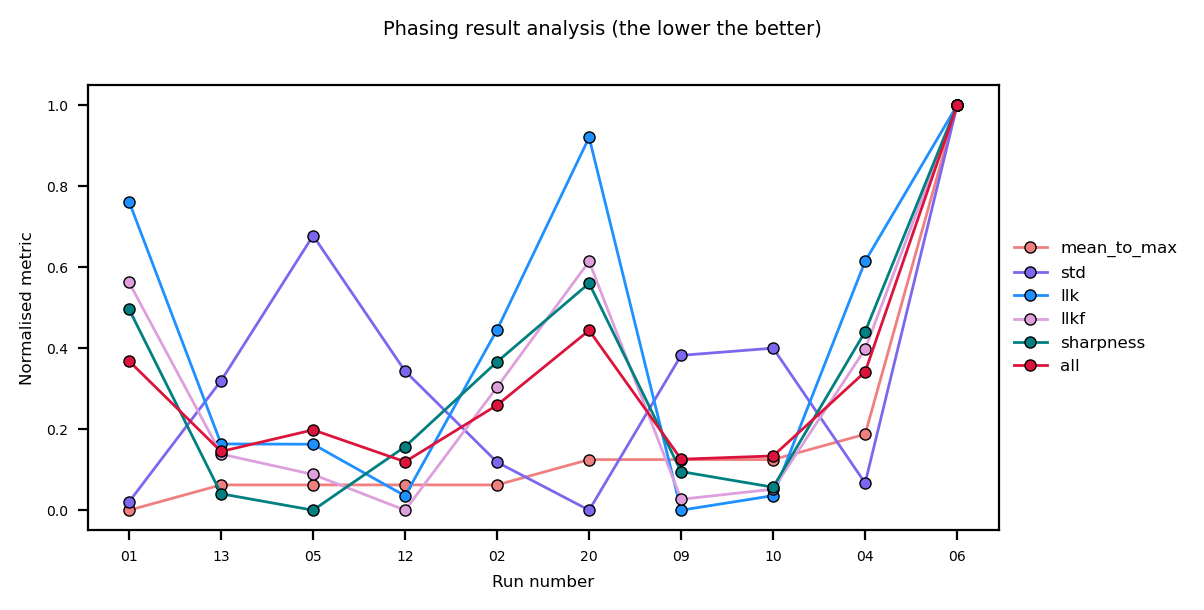

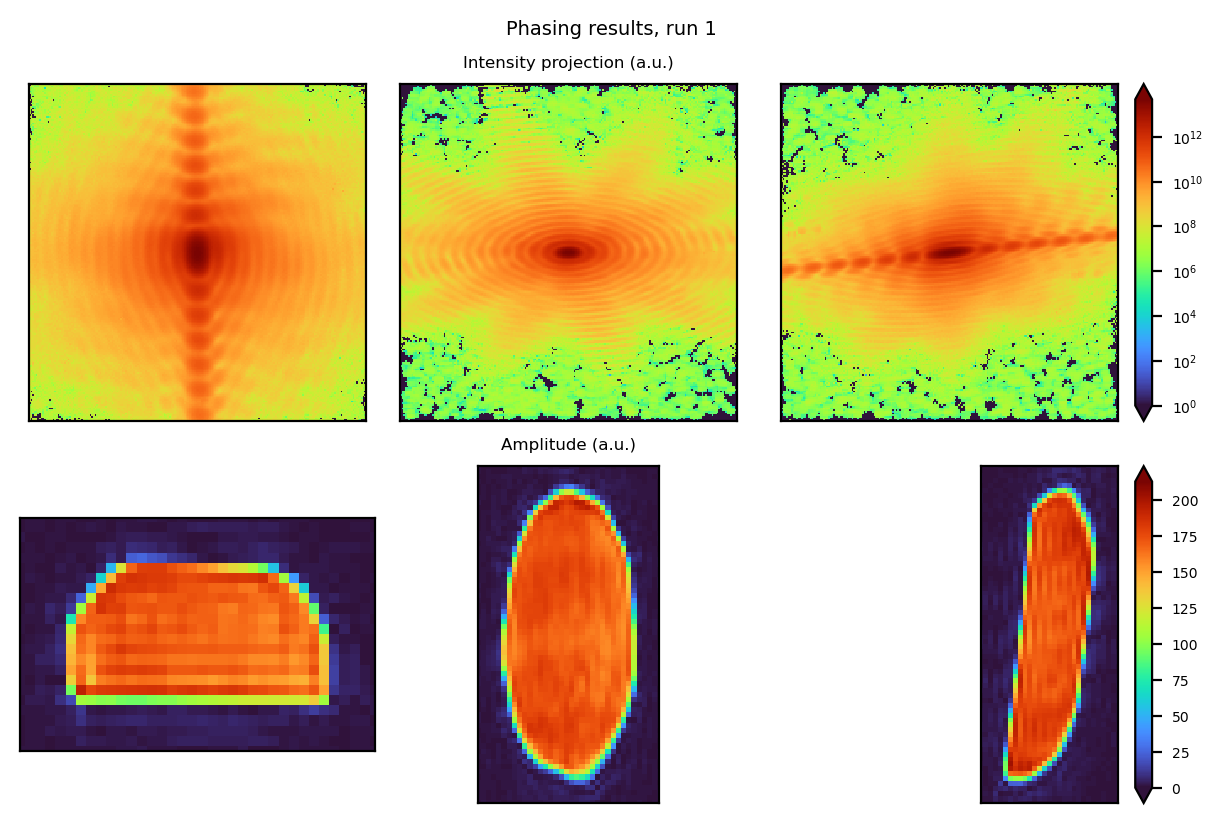

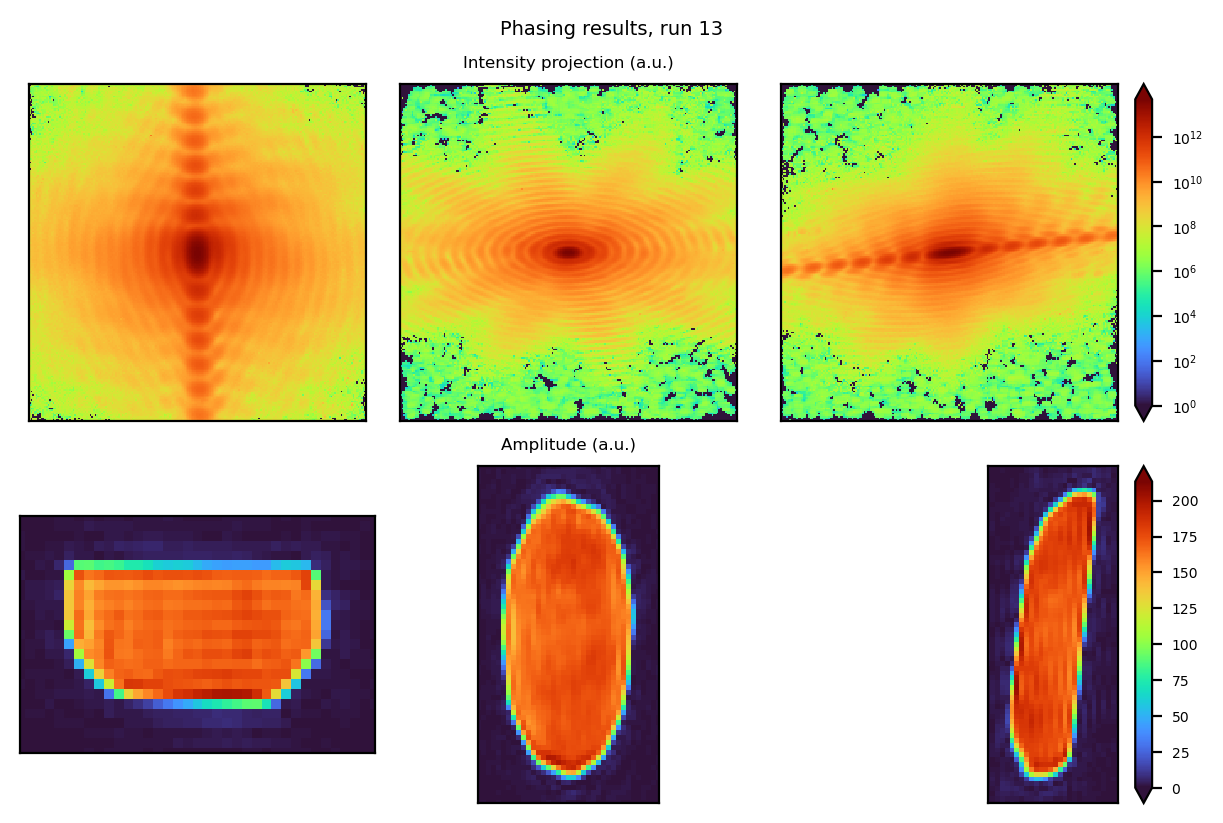

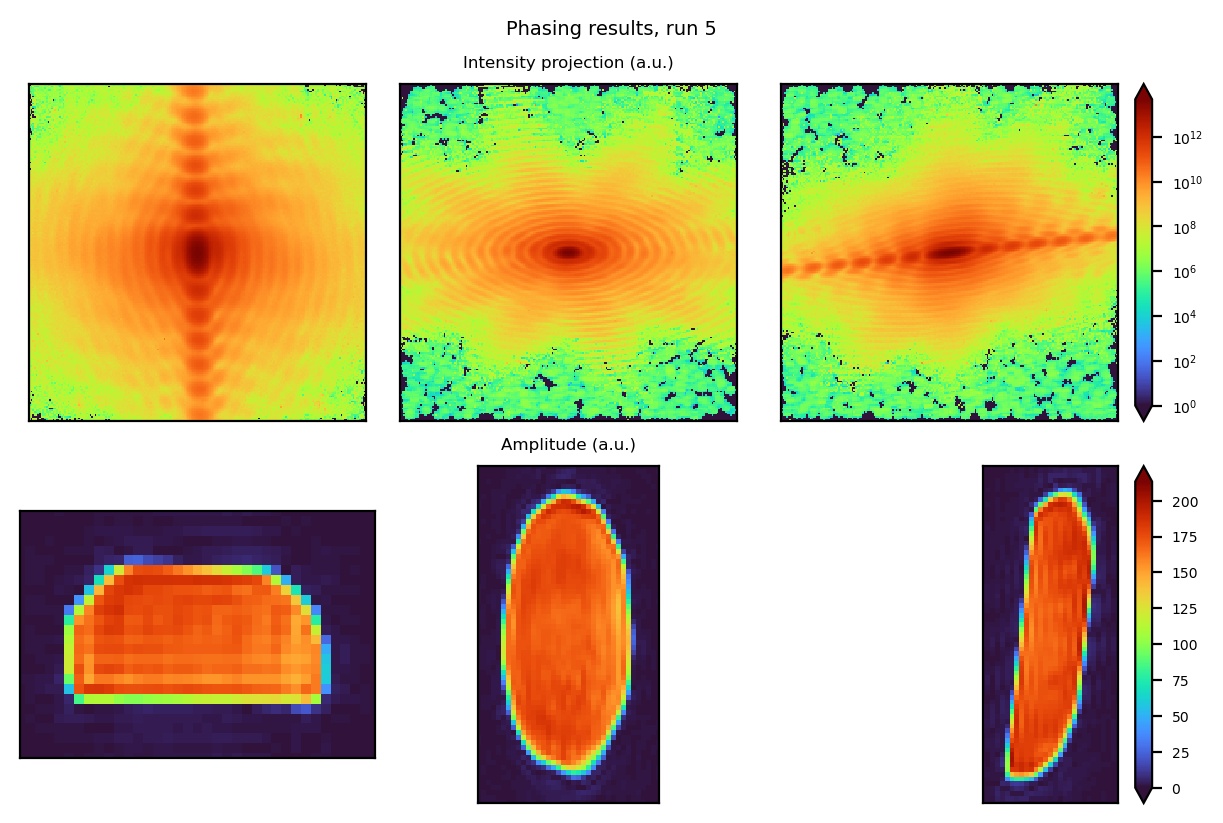

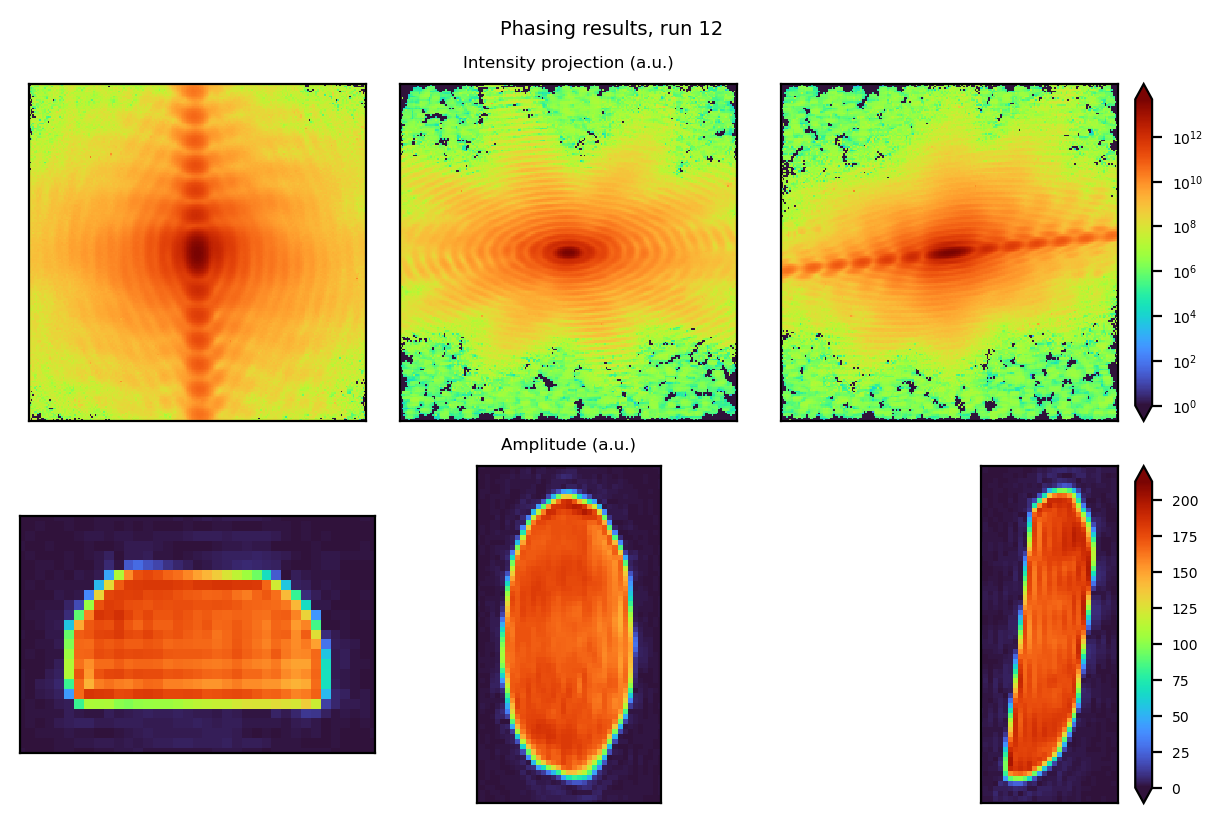

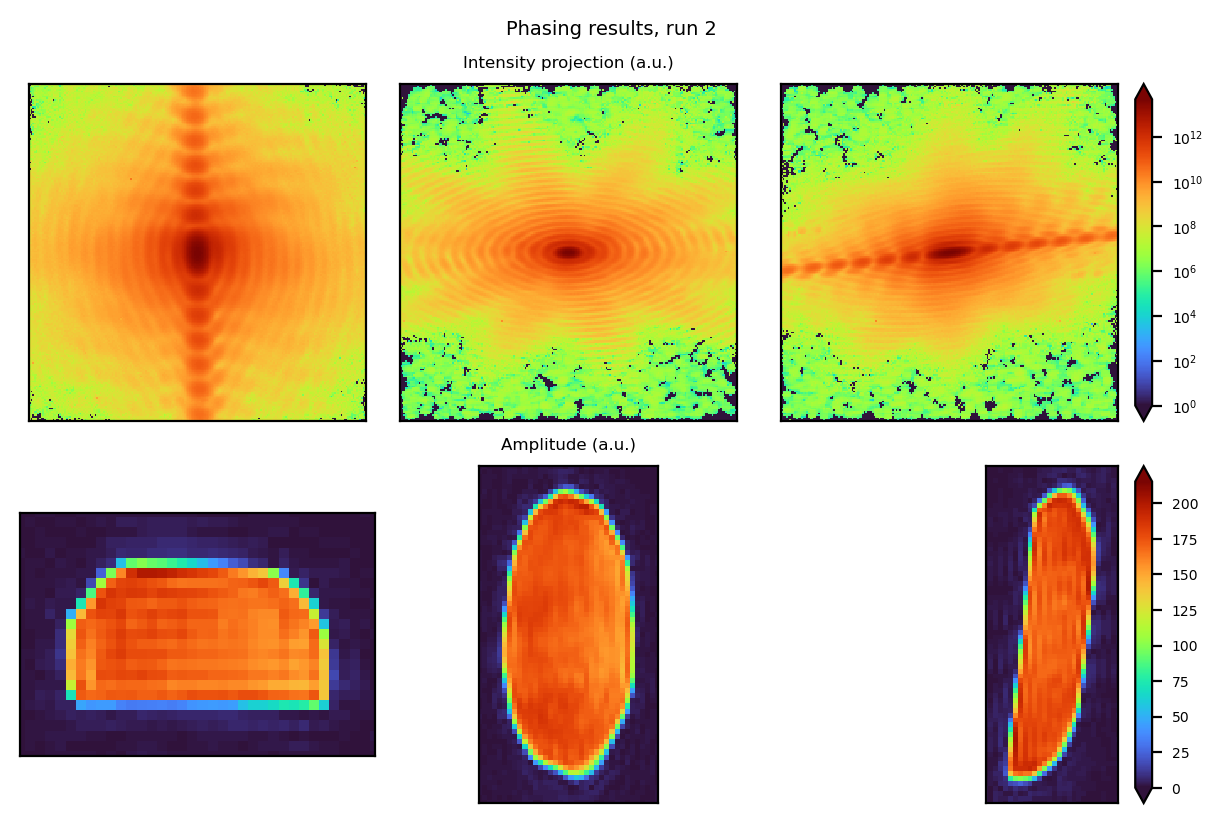

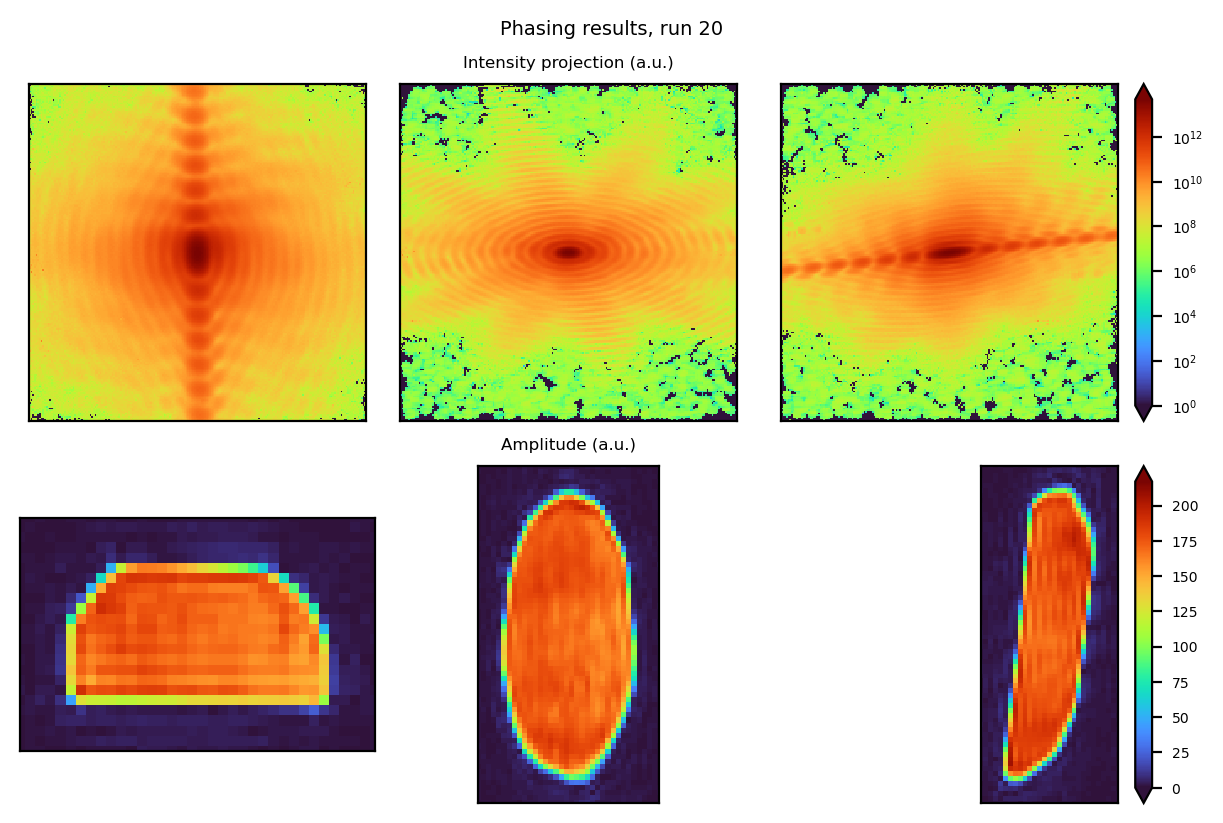

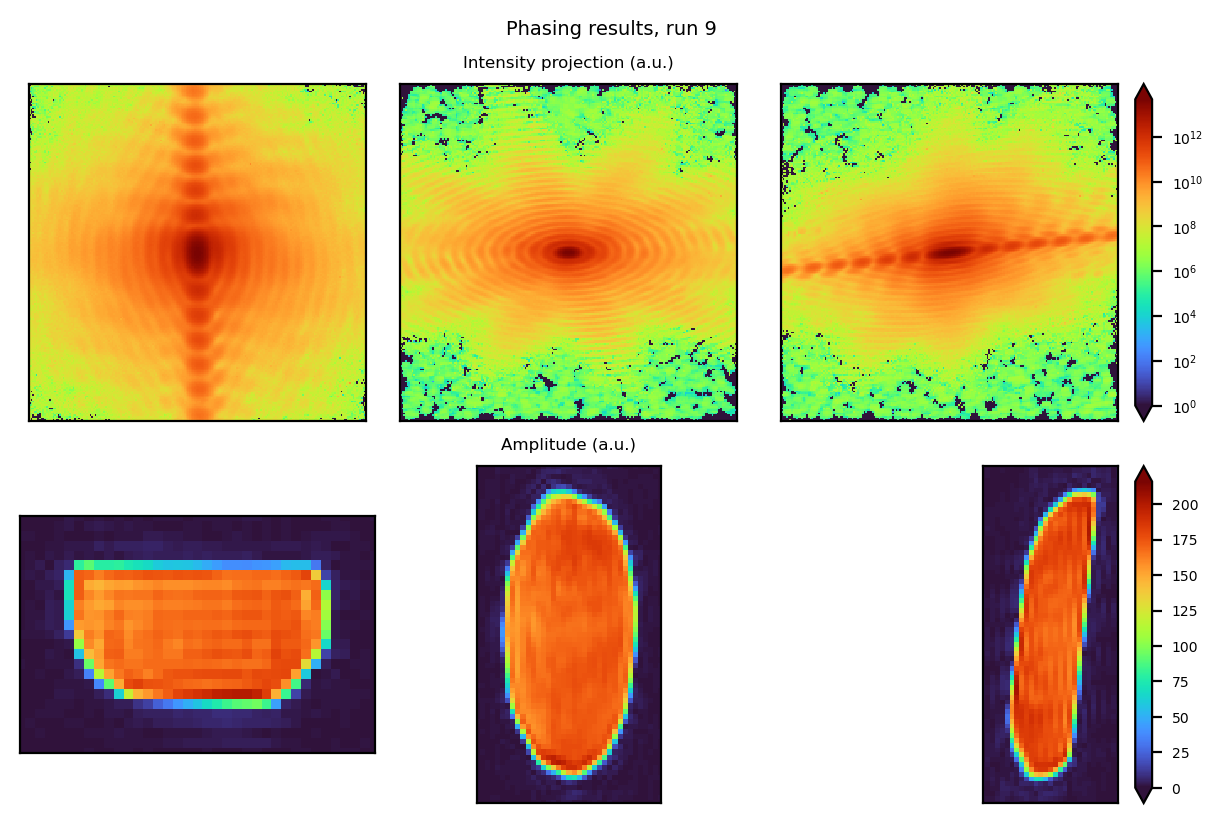

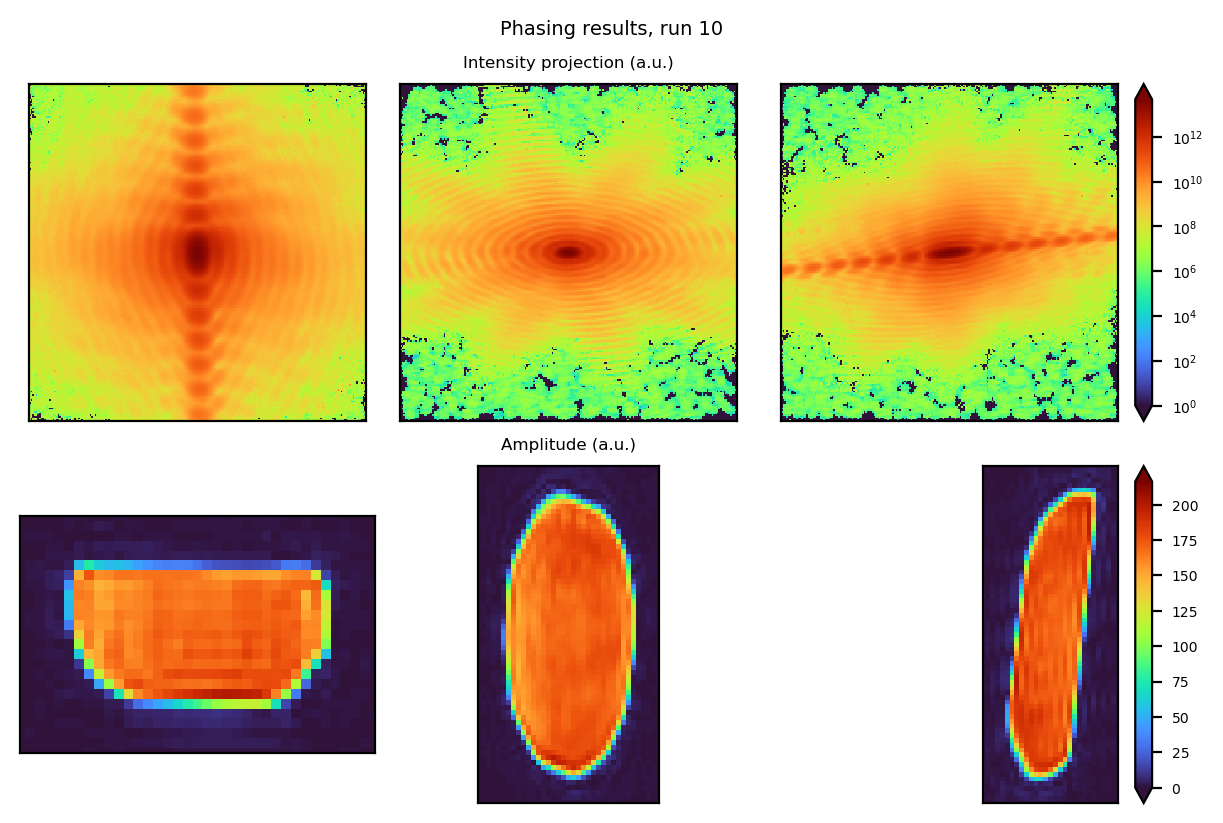

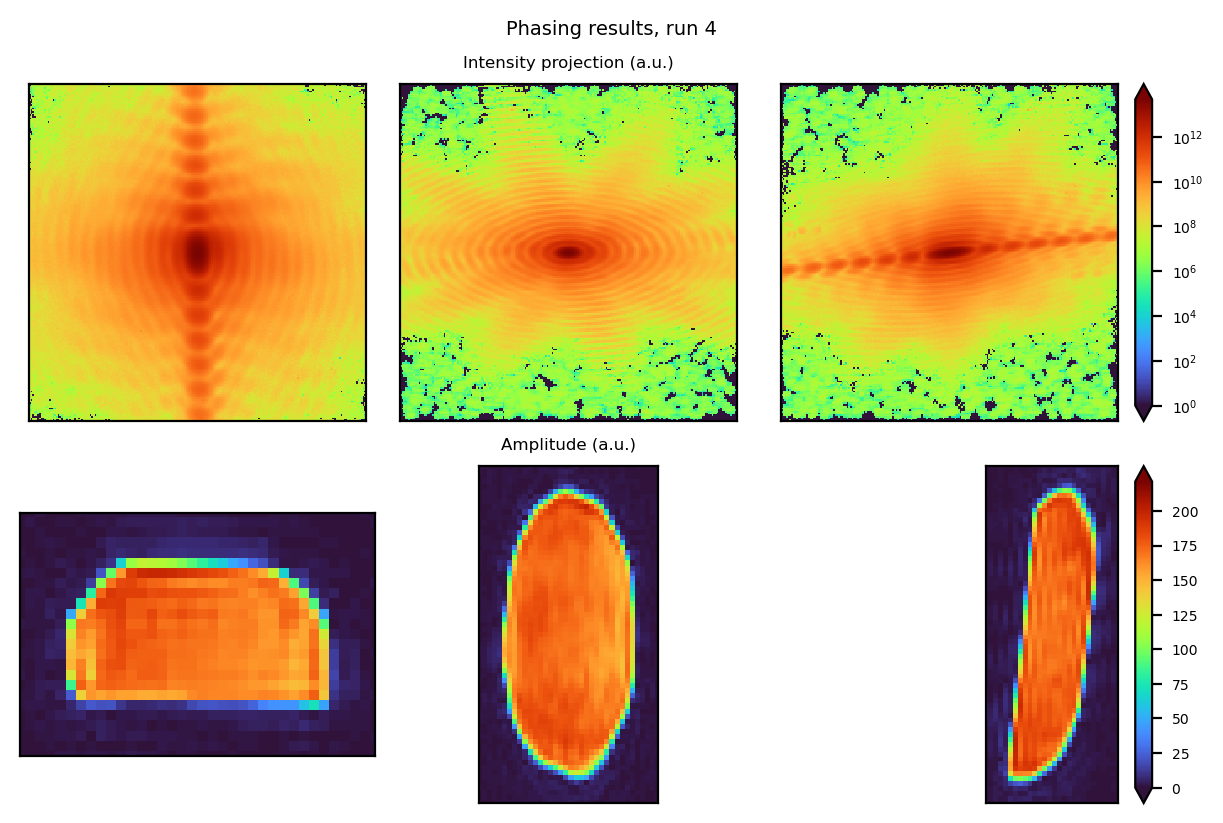

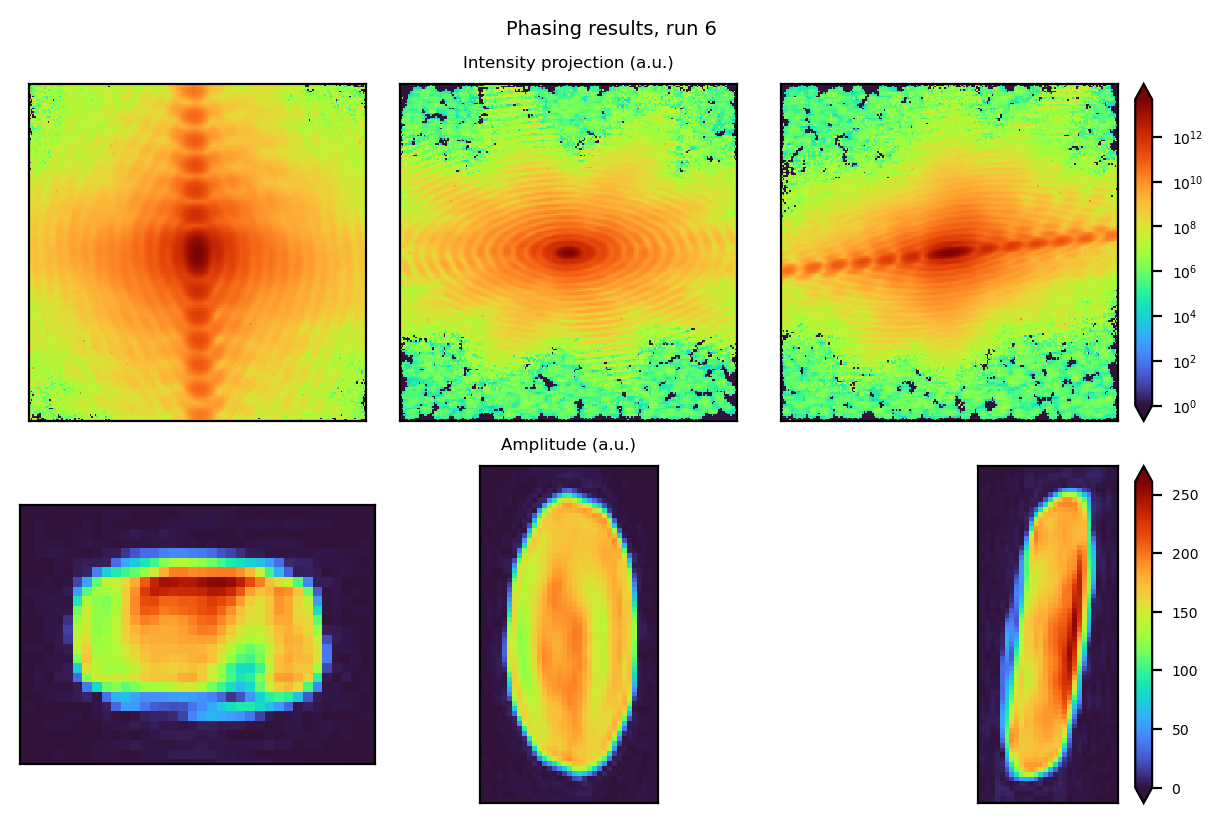

In [6]:
bcdi_pipeline.analyse_phasing_results(
    sorting_criterion="mean_to_max",  # selects the sorting method
    # Optional parameters
    # plot_phasing_results=False,  # uncomment to disable plotting
    # plot_phase=True,  # uncomment to enable phase plotting
)

### **Optionally, generate a support for further phasing attempts**  

##### **Parameters**
- `run` → set to either:  
  - `"best"` to use the best reconstruction.  
  - an **integer** corresponding to the specific run you want.  
- `output_path` → the location to save the generated support. By default, it will be saved in the `pynx_phasing` folder.  
- `fill` →  whether to fill the support if it contains holes.  
  - Default: `False`.
- `verbose` → whether to print logs and display a plot of the support.  

<!-- ```python
bcdi_pipeline.generate_support_from(run="best", output_path="path/to/save", verbose=True)
``` -->

In [ ]:
# bcdi_pipeline.generate_support_from("best", fill=False)  # uncomment to generate a support

### **Selection of the best reconstructions & mode decomposition**

You can select the best reconstructions based on a **sorting criterion** and keep a specified number of top candidates.  

##### **Parameters**
- `nb_of_best_sorted_runs` → the number of best reconstructions to keep, selected based on the `sorting_criterion` used in the `analyse_phasing_results` method above.  
- `best_runs` → instead of selecting based on sorting, you can manually specify a list of reconstruction numbers.

By default, the **best reconstructions** are automatically selected.  

Once the best candidates are chosen, `mode_decomposition` analyses them to extract dominant features.  



In [7]:
# define how many of the best candidates to keep
number_of_best_candidates: int = 5

# select the best reconstructions based on the sorting criterion
bcdi_pipeline.select_best_candidates(
    nb_of_best_sorted_runs=number_of_best_candidates
    # best_runs=[10]  # uncomment to manually select a specific run
)

# perform mode decomposition on the selected reconstructions
bcdi_pipeline.mode_decomposition()

[INFO] Best candidates selected:
['01', '13', '05', '12', '02']


[INFO] 
*******************************************************************************
*                    Starting process: mode_decomposition                     *
*******************************************************************************

[INFO] 
R_match(1) = 16.260 %

[INFO] 
R_match(2) =  9.014 %

[INFO] 
R_match(3) =  7.480 %

[INFO] 
R_match(4) = 14.811 %

[INFO] 
First mode represents 99.127 %

[INFO] Process mode_decomposition completed successfully.


## **Post-processing**

This stage includes several key operations:  
- **orthogonalisation** of the reconstructed data.  
- **phase manipulation**:  
  - phase unwrapping  
  - phase ramp removal  
- **computation of physical properties**:  
  - displacement field  
  - strain  
  - d-spacing  
- **visualisation**: Generate multiple plots for analysis.  


[INFO] 
*******************************************************************************
*                        Starting process: postprocess                        *
*******************************************************************************

[INFO] Additional parameters provided {'isosurface': 0.5, 'voxel_size': None, 'flip': True}, will update the current dictionary of parameters.
[INFO] The oversampling ratios in each direction (original frame) are axis0: 3.4, axis1: 11.8, axis2: 8.0
[INFO] Voxel size finally used is: (6.522021030191126, 14.834154502665216, 14.246443288915062) nm in the CXI convention.
[INFO] Apodizing the complex array using blackman filter.
[INFO] Finding an isosurface estimate based on the reconstructed Bragg electron density histogram:
[INFO] Isosurface estimated at 0.7425768604033756.
[INFO] Isosurface provided by user will be used: 0.5.
[INFO] Computing the structural properties:
	- phase 
	- displacement
	- het. (heterogeneous) strain
	- d-spacing
	- la

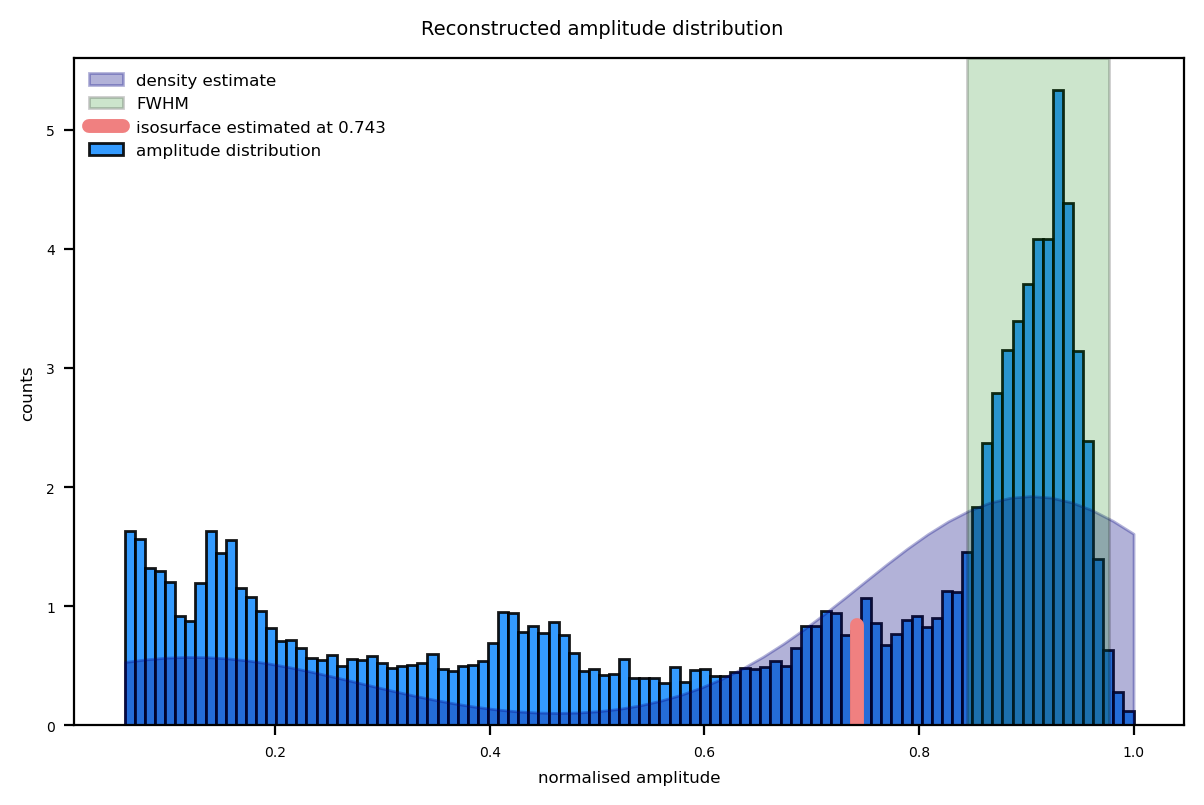

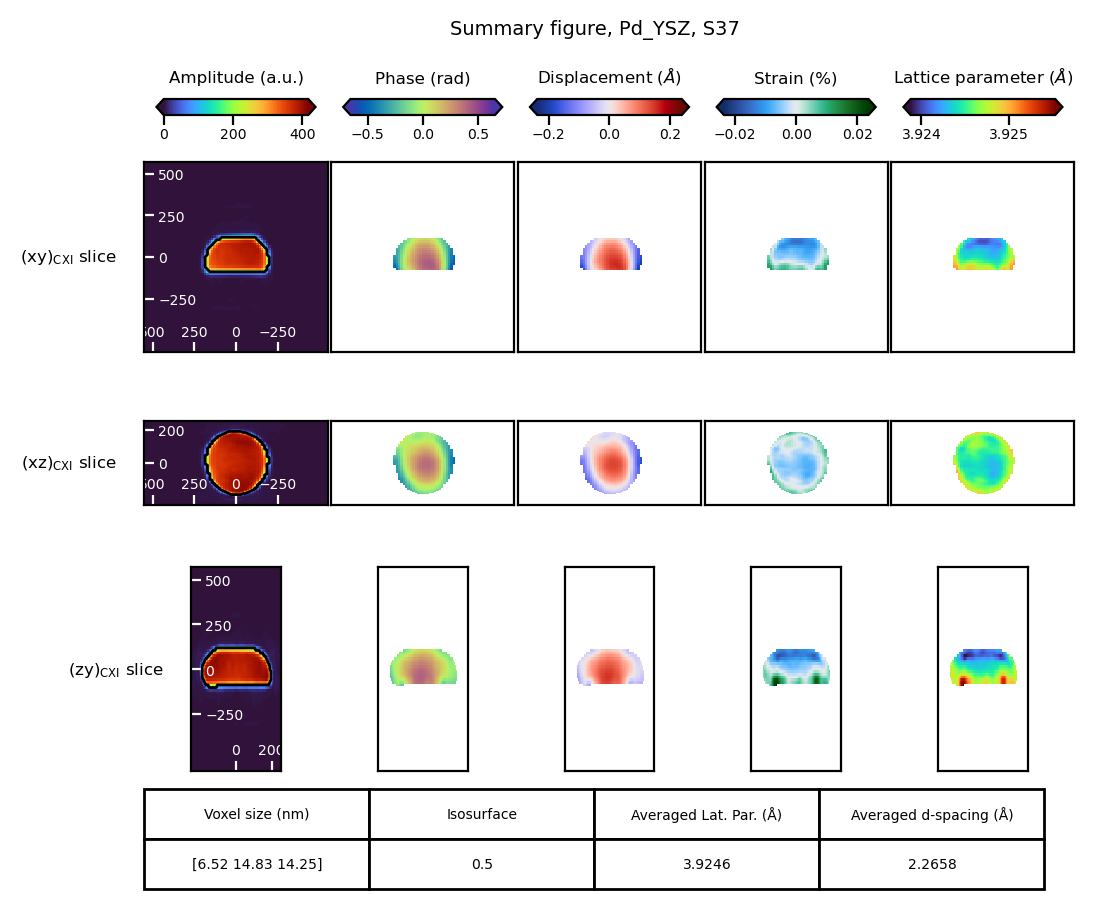

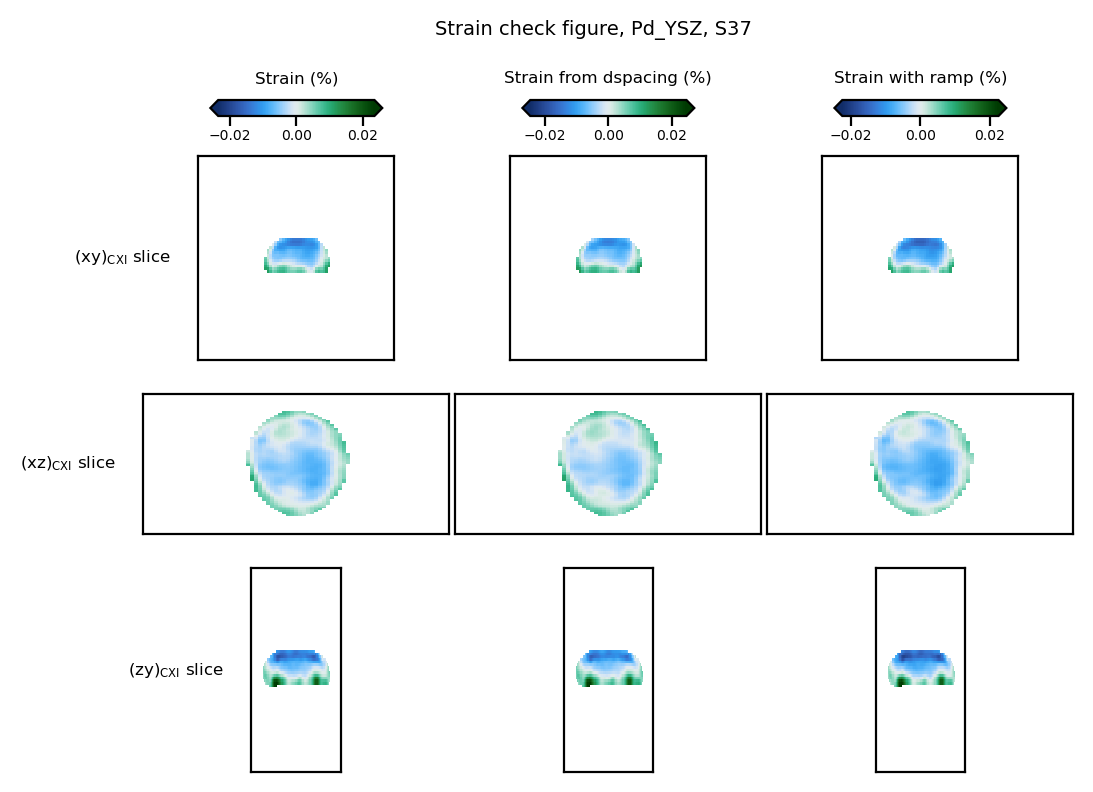

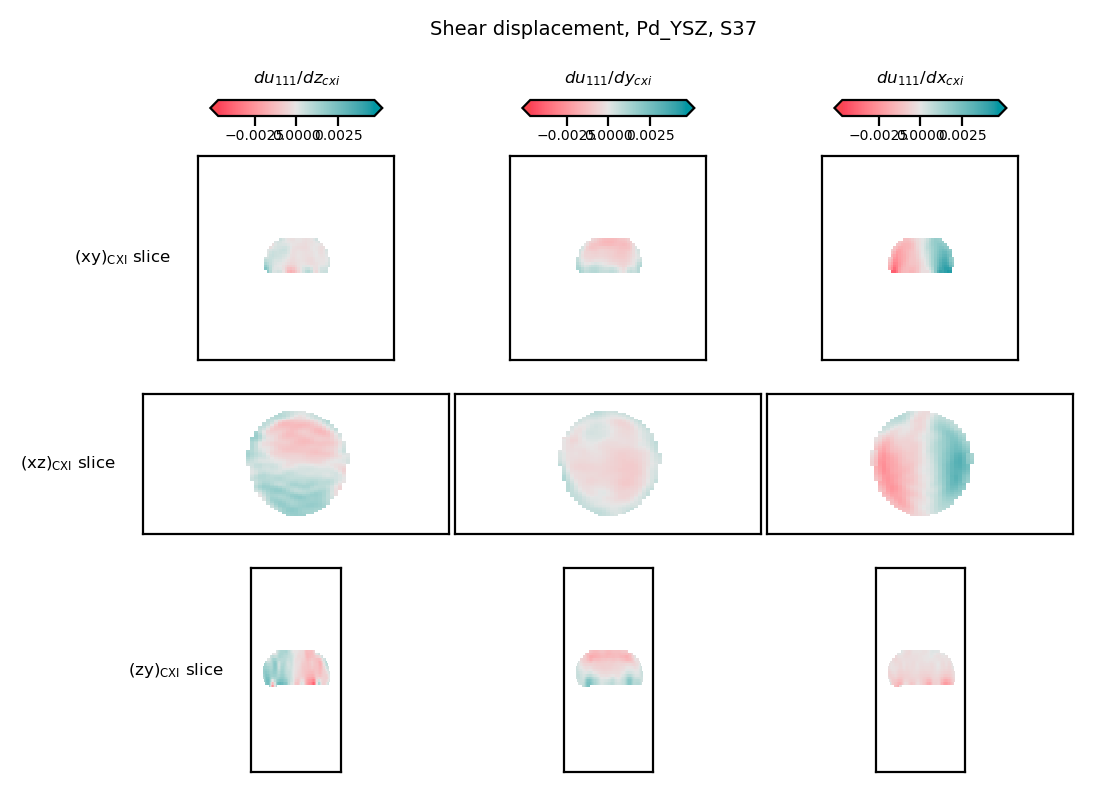

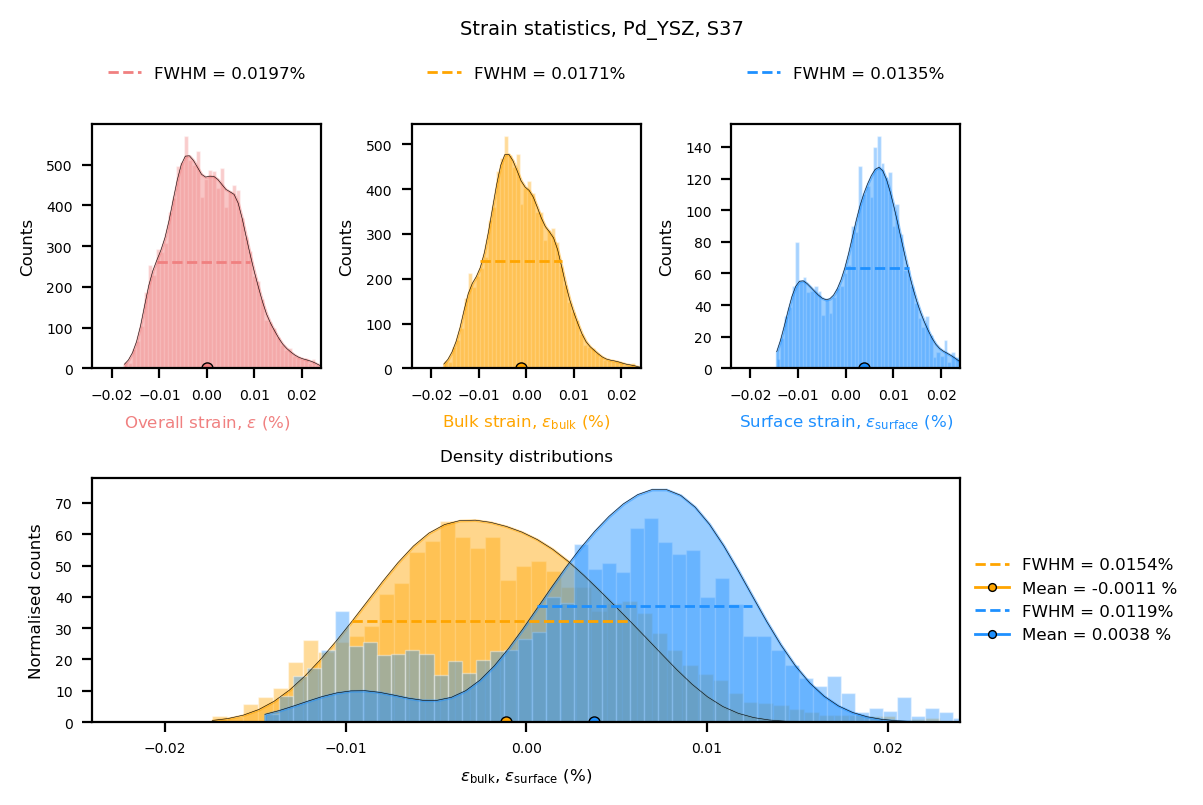

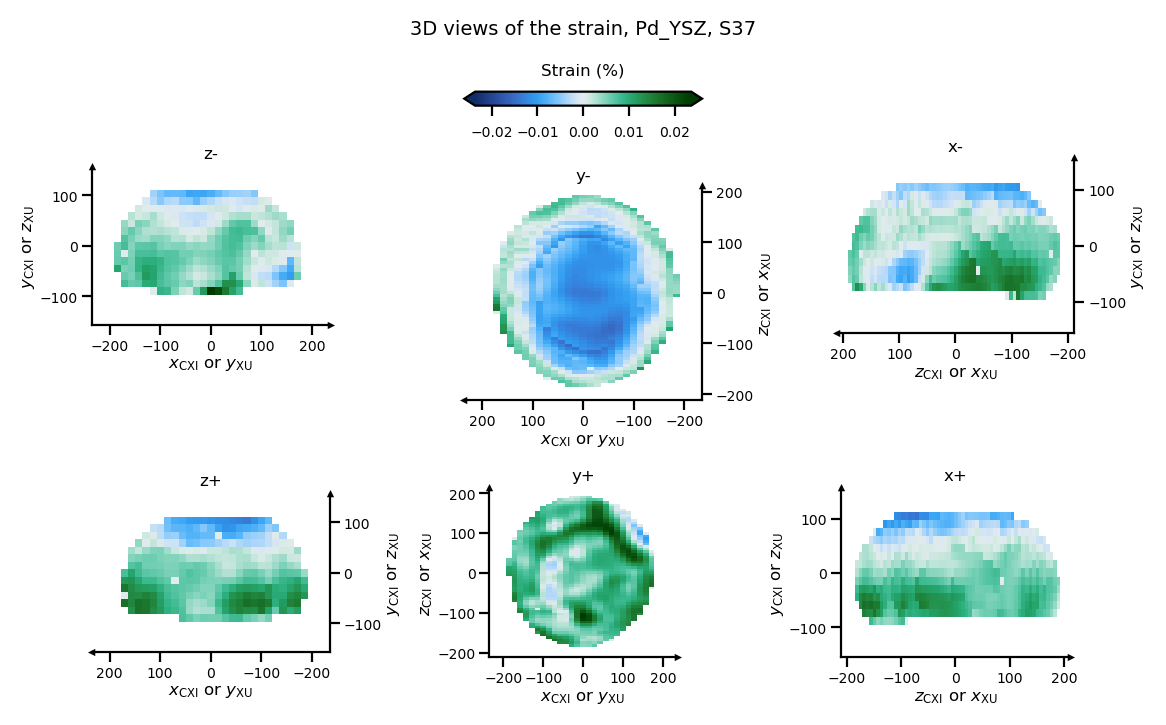

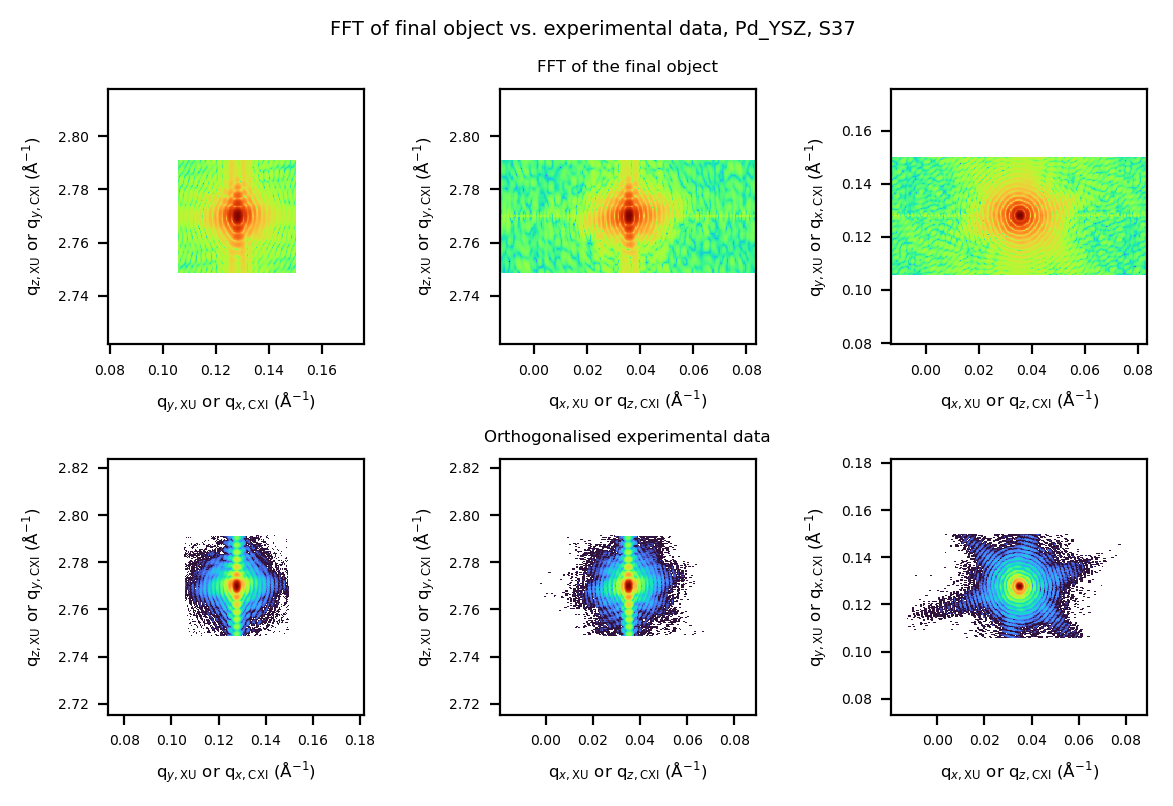

In [10]:
bcdi_pipeline.postprocess(
    isosurface=0.5,  # threshold for isosurface
    voxel_size=None,  # use default voxel size if not provided
    flip=True,  # whether to flip the reconstruction if you got the twin image (enantiomorph)
)

## **3D interactive plot**

Display an interactive 3D isosurface of the final reconstruction and explore different quantities for colouring.

What you can do
- Visualise an isosurface of the reconstructed object (amplitude / support).
- Colour the surface by different quantities: amplitude, phase, displacement, strain, d-spacing, etc.
- Interactively adjust:
    - isosurface threshold (isosurface level)
    - colormap and value range
- Rotate, zoom and pan the scene with the mouse; use the toolbar to reset view or save a screenshot.


In [11]:
bcdi_pipeline.show_3d_final_result()

## **Feedback & Issue Reporting**  

If you have **comments, suggestions, or encounter any issues**, please reach out:  

📧 **Email:** [clement.atlan@esrf.fr](mailto:clement.atlan@esrf.fr?subject=cdiutils)  
🐙 **GitHub Issues:** [Report an issue](https://github.com/clatlan/cdiutils/issues)  


## Credits
This notebook was created by Clément Atlan, ESRF, 2025. It is part of the `cdiutils` package, which provides tools for BCDI data analysis and visualisation.
If you have used this notebook or the `cdiutils` package in your research, please consider citing the package https://github.com/clatlan/cdiutils/
You'll find the citation information in the `cdiutils` package documentation.

```bibtex
@software{Atlan_Cdiutils_A_python,
author = {Atlan, Clement},
doi = {10.5281/zenodo.7656853},
license = {MIT},
title = {{Cdiutils: A python package for Bragg Coherent Diffraction Imaging processing, analysis and visualisation workflows}},
url = {https://github.com/clatlan/cdiutils},
version = {0.2.0}
}
```

